In [1]:
import os
# Install java
! sudo apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [2]:
!java -version
!free -g

openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~deb9u1-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)
              total        used        free      shared  buff/cache   available
Mem:             51           2          44           0           3          47
Swap:             0           0           0


In [ ]:
!pip install --ignore-installed -q pyspark==2.4.5
!gsutil cp gs://hadoop-lib/gcs/gcs-connector-hadoop2-latest.jar /opt/conda/lib/python3.7/site-packages/pyspark/jars/
    
!pip install --ignore-installed spark-nlp==2.5.1
!pip install wordcloud


In [2]:
import sparknlp
import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from sparknlp.annotator import *
from sparknlp.base import *
from pyspark.sql.functions import from_unixtime
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col, to_timestamp,date_format
from pyspark import StorageLevel
import pyspark.sql.functions as F
from sparknlp.pretrained import PretrainedPipeline
from collections import Counter
from wordcloud import WordCloud
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (Tokenizer, Normalizer,LemmatizerModel, StopWordsCleaner)
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

def start():
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "40G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2040M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.5.1") \
        .config("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
        .config("fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS")
    return builder.getOrCreate()
spark = start()
spark.version
!ps -ef | grep spark

jupyter   2116  2099 99 23:46 ?        00:00:16 /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java -cp /opt/conda/lib/python3.7/site-packages/pyspark/conf:/opt/conda/lib/python3.7/site-packages/pyspark/jars/* -Xmx40G org.apache.spark.deploy.SparkSubmit --conf spark.master=local[*] --conf spark.driver.memory=40G --conf spark.kryoserializer.buffer.max=2040M --conf spark.jars.packages=com.johnsnowlabs.nlp:spark-nlp_2.11:2.5.1 --conf spark.serializer=org.apache.spark.serializer.KryoSerializer --conf spark.app.name=Spark NLP Licensed --conf fs.AbstractFileSystem.gs.impl=com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS --conf fs.gs.impl=com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem pyspark-shell
jupyter   2290  2099  0 23:46 pts/2    00:00:00 /bin/sh -c ps -ef | grep spark
jupyter   2292  2290  0 23:46 pts/2    00:00:00 grep spark


In [ ]:
#spark.version
!ps -ef | grep spark
#!kill -9 27998

In [3]:
nltk.download('stopwords')
eng_stopwords = stopwords.words('english')

def wordcloud(corpus_sdf):
    corpus_pdf = corpus_sdf.limit(500).toPandas()

    corpus_dict = {}
    for index, row in corpus_pdf.iterrows():
        corpus_dict[row['text']] = row['count']
        
    wordcloud = WordCloud().generate_from_frequencies(corpus_dict)
    plt.imshow(wordcloud);
    
def remove_stopwords(x):    
    sw = stopwords.words("english")
    string = ''
    for x in x.split(' '):
        if x.lower() not in sw:
            string += x + ' '
        else:
            pass
    return string

nosw = udf(remove_stopwords)
spark.udf.register("nosw", nosw)

documentAssembler = DocumentAssembler() \
    .setInputCol('text') \
    .setOutputCol('document')

tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')

# note normalizer defaults to changing all words to lowercase.
# Use .setLowercase(False) to maintain input case.
normalizer = Normalizer() \
    .setInputCols(['token']) \
    .setOutputCol('normalized') \
    .setLowercase(True)

# note that lemmatizer needs a dictionary. So I used the pre-trained
# model (note that it defaults to english)
lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(['normalized']) \
    .setOutputCol('lemma') \

stopwords_cleaner = StopWordsCleaner() \
    .setInputCols(['lemma']) \
    .setOutputCol('clean_lemma') \
    .setCaseSensitive(False) \
    .setStopWords(eng_stopwords) 

#eng_stopwords

# finisher converts tokens to human-readable output
finisher = Finisher() \
    .setInputCols(['clean_lemma']) \
    .setCleanAnnotations(False)

pipeline = Pipeline() \
    .setStages([
        documentAssembler,
        tokenizer,
        normalizer,
        lemmatizer,
        stopwords_cleaner,
        finisher
    ])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [16]:
spark.conf.set("spark.sql.files.ignoreCorruptFiles", "true")
df_part1 = spark.read.option("multiline","true").format("json").load( "gs://covid19-tweets/2020-03/coronavirus-tweet-id-2020-03-0*.gz")
df_part2 = spark.read.option("multiline","true").format("json").load( "gs://covid19-tweets/2020-03/coronavirus-tweet-id-2020-03-1*.gz")
df_part3 = spark.read.option("multiline","true").format("json").load( "gs://covid19-tweets/2020-03/coronavirus-tweet-id-2020-03-2*.gz")
df_part4 = spark.read.option("multiline","true").format("json").load( "gs://covid19-tweets/2020-03/coronavirus-tweet-id-2020-03-3*.gz")

In [15]:
def createWordCloud(query, clusterType):
    tempDF = spark.sql(query)
    cleanDFa = pipeline.fit(tempDF).transform(tempDF) # without stop words
    tokenDFa = cleanDFa.withColumn("exploded_text", explode(col("finished_clean_lemma")))
    countTermDFa = tokenDFa.groupby('exploded_text').count().withColumnRenamed("exploded_text","text")
    #spark.sql("""drop table if exists  countTermDFPart""")
    #countTermDFa.repartition(5).write.mode('overwrite').saveAsTable("countTermDFPart")
    countTermDFa.createOrReplaceTempView(clusterType)
    countTermDFQry = 'select text, count from {} where lower(text) not rlike ("corona|coronavirus|covid|get|say|en|el|de|rt|se|le|para|la|los|les|por|di|like|queue|un|es|today|anyone|may|una|also|amp|lo|sus|go|agua|con|get|que|manas") order by count desc limit 100'.format(clusterType)
    topTermsDFa = spark.sql(countTermDFQry)

    fig, ax = plt.subplots(nrows=1, figsize=(10,10))
    ax = wordcloud(topTermsDFa)
    fig.suptitle('{} wordcloud'.format(clusterType))
    plt.tight_layout();
    
    #spark.catalog.dropTempView(clusterType)

In [ ]:
def test(tabName):
    query = 'desc {}'.format(tabName)
    spark.sql(query).show()

In [19]:
spark.conf.set("spark.sql.legacy.allowCreatingManagedTableUsingNonemptyLocation","true")
df1a = df_part4.where(col("full_text").isNotNull()).withColumnRenamed("full_text","text").withColumn('event_date', from_unixtime(unix_timestamp(col("created_at"),"EEE MMM dd HH:mm:ss ZZZZ yyyy"),"yyyy-MM-dd"))
df1a = df1a.withColumn('text',nosw('text'))
df1b = df1a.select("event_date","coordinates","geo","place","text")
df1b.repartition(5).write.mode('overwrite').saveAsTable("marchTweetsPart4")

+----------+-----------+----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|event_date|coordinates| geo|place|                text|            document|               token|          normalized|               lemma|         clean_lemma|finished_clean_lemma|
+----------+-----------+----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|2020-03-03|       null|null| null|RT @SIMV_RP: Chin...|[[document, 0, 13...|[[token, 0, 1, RT...|[[token, 0, 1, rt...|[[token, 0, 1, rt...|[[token, 0, 1, rt...|[rt, simvrp, chin...|
|2020-03-03|       null|null| null|RT @DidierMaisto:...|[[document, 0, 89...|[[token, 0, 1, RT...|[[token, 0, 1, rt...|[[token, 0, 1, rt...|[[token, 0, 1, rt...|[rt, didiermaisto...|
+----------+-----------+----+-----+--------------------+--------------------+--------

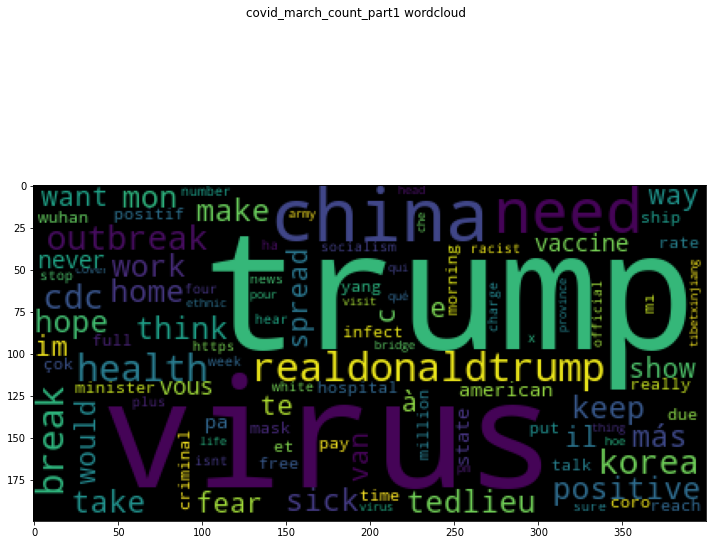

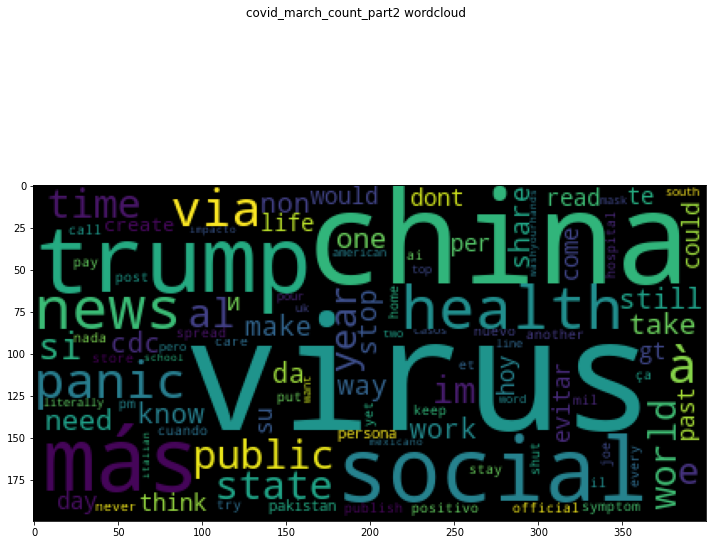

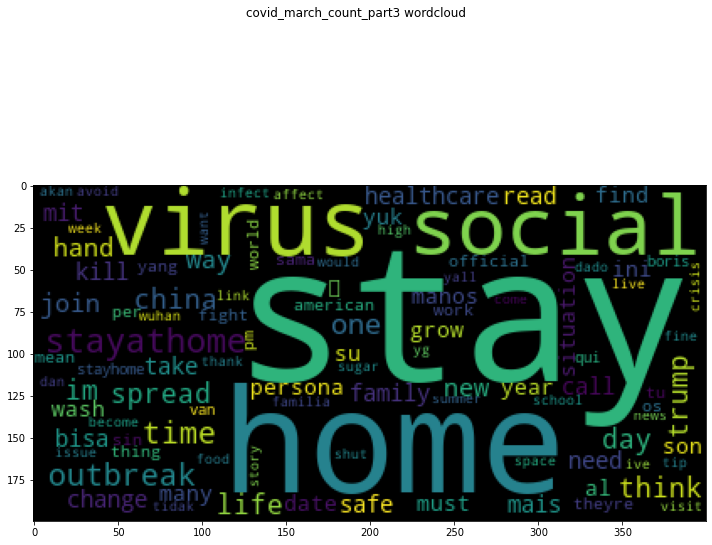

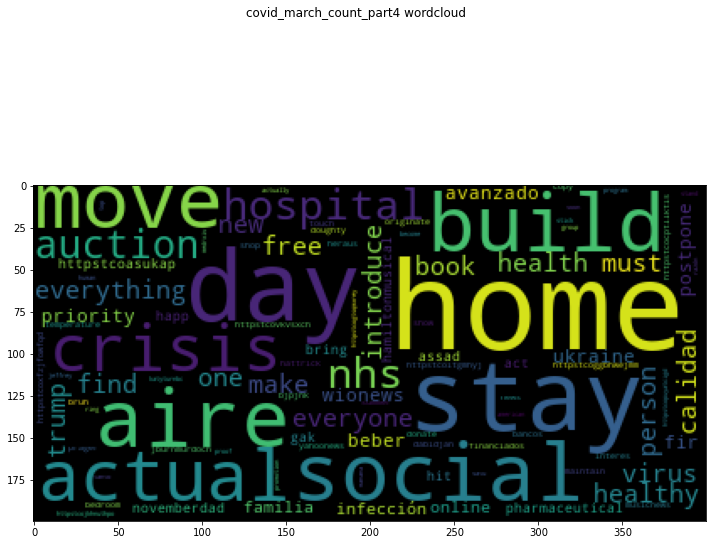

In [17]:
spark.conf.set("spark.sql.legacy.allowCreatingManagedTableUsingNonemptyLocation","true")
df1a = df_part1.where(col("full_text").isNotNull()).withColumnRenamed("full_text","text").withColumn('event_date', from_unixtime(unix_timestamp(col("created_at"),"EEE MMM dd HH:mm:ss ZZZZ yyyy"),"yyyy-MM-dd"))
df1a = df1a.withColumn('text',nosw('text'))
df1b = df1a.select("event_date","coordinates","geo","place","text")
df1b.repartition(5).write.mode('overwrite').saveAsTable("marchTweetsPart1")
query = """select event_date,coordinates,geo,place,text from marchTweetsPart1"""
createWordCloud(query,"covid_march_count_part1")

df2a = df_part2.where(col("full_text").isNotNull()).withColumnRenamed("full_text","text").withColumn('event_date', from_unixtime(unix_timestamp(col("created_at"),"EEE MMM dd HH:mm:ss ZZZZ yyyy"),"yyyy-MM-dd"))
df2a = df2a.withColumn('text',nosw('text'))
df2b = df2a.select("event_date","coordinates","geo","place","text")
df2b.repartition(5).write.mode('overwrite').saveAsTable("marchTweetsPart2")
query = """select event_date,coordinates,geo,place,text from marchTweetsPart2"""
createWordCloud(query,"covid_march_count_part2")

df3a = df_part3.where(col("full_text").isNotNull()).withColumnRenamed("full_text","text").withColumn('event_date', from_unixtime(unix_timestamp(col("created_at"),"EEE MMM dd HH:mm:ss ZZZZ yyyy"),"yyyy-MM-dd"))
df3a = df3a.withColumn('text',nosw('text'))
df3b = df3a.select("event_date","coordinates","geo","place","text")
df3b.repartition(5).write.mode('overwrite').saveAsTable("marchTweetsPart3")
query = """select event_date,coordinates,geo,place,text from marchTweetsPart3"""
createWordCloud(query,"covid_march_count_part3")

df4a = df_part4.where(col("full_text").isNotNull()).withColumnRenamed("full_text","text").withColumn('event_date', from_unixtime(unix_timestamp(col("created_at"),"EEE MMM dd HH:mm:ss ZZZZ yyyy"),"yyyy-MM-dd"))
df4a = df4a.withColumn('text',nosw('text'))
df4b = df4a.select("event_date","coordinates","geo","place","text")
df4b.repartition(5).write.mode('overwrite').saveAsTable("marchTweetsPart4")
query = """select event_date,coordinates,geo,place,text from marchTweetsPart4"""
createWordCloud(query,"covid_march_count_part4")

## Term Stats

In [ ]:
clusterType = "covid_march_count_part1"
query ='select text, count from {} where lower(text) not rlike ("corona|coronavirus|covid|get|say|en|el|de|rt|se|le|para|la|los|les|por|di|like|queue|un|es|today|anyone|may|una|also|amp|lo|sus|go|agua|con|get|que|manas") order by count desc limit 20'.format(clusterType)
countTermDFQry = spark.sql(query)
pdf1=countTermDFQry.toPandas()
pdf1.plot(kind='barh',x='text',y='count',colormap='winter_r')

In [ ]:
countTermDFQry.select('count').rdd.flatMap(lambda x: x).histogram(20)

In [ ]:
#https://github.com/matplotlib/ipympl
#!pip install ipympl
#!pip install nodejs
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
#!jupyter lab build

## Sentiment Analysis

In [ ]:
#!pip install vaderSentiment
import sparknlp
import json
import os
from sparknlp.annotator import *
from sparknlp.base import *
from pyspark.sql.functions import from_unixtime
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import *
from pyspark.sql.functions import explode, col
from pyspark.sql.functions import from_unixtime, to_date, asc, year, udf, explode, split, col, desc, length, rank, dense_rank, avg, sum

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def calc_polarity(text):    
    cp = analyser.polarity_scores(text)['compound']
    if (cp > -0.99 and cp < -0.2):
        return "HN"
    elif (cp > -0.2 and cp < 0.05):
        return "LN"
    elif (cp > 0.1 and cp < 0.4):
        return "LP"
    elif (cp > 0.4 and cp < 1.0):
        return "HP"
    
calc_polarity = udf(calc_polarity)
spark.udf.register("calc_polarity", calc_polarity)
#query1 = """select event_date,coordinates,geo,place,text from marchTweetsPart1"""
#createTermFrequency(query1)


In [29]:
tempDF = spark.sql("""select event_date,coordinates,geo,place,text from marchTweetsPart1""")
cleanDFa = pipeline.fit(tempDF).transform(tempDF) # without stop words
tokenDFa = cleanDFa.withColumn("exploded_text", explode(col("finished_clean_lemma"))).withColumn('sentiment',calc_polarity('text'))
tokenDFa.createOrReplaceTempView("cleanTokens")
spark.sql("""select sentiment, count(*) from cleanTokens group by sentiment""").show(10)

+---------+--------+
|sentiment|count(1)|
+---------+--------+
|       LN|    1573|
|       HP|     546|
|       HN|     542|
|       LP|     293|
+---------+--------+



+-----------+-----+
|       text|count|
+-----------+-----+
|coronavirus|   17|
|      trump|    4|
+-----------+-----+
only showing top 2 rows



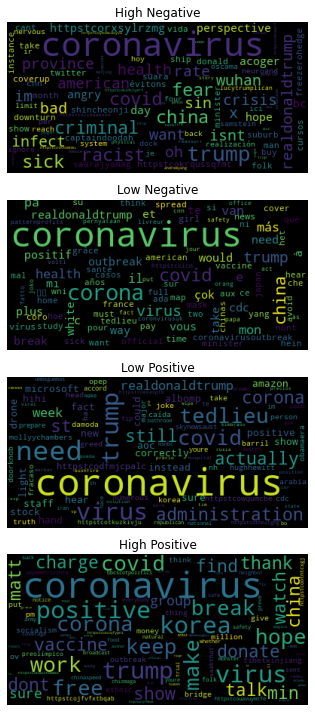

In [40]:
createTermFrequency()

In [26]:
tempDF = spark.sql("""select event_date,coordinates,geo,place,text from marchTweetsPart2""")
cleanDFa = pipeline.fit(tempDF).transform(tempDF) # without stop words
tokenDFa = cleanDFa.withColumn("exploded_text", explode(col("finished_clean_lemma"))).withColumn('sentiment',calc_polarity('text'))
tokenDFa.createOrReplaceTempView("cleanTokens")
spark.sql("""select sentiment, count(*) from cleanTokens group by sentiment""").show(10)

+---------+--------+
|sentiment|count(1)|
+---------+--------+
|       LN|    2185|
|       HP|     710|
|       HN|     575|
|       LP|     406|
+---------+--------+



+-----------+-----+
|       text|count|
+-----------+-----+
|coronavirus|   17|
|      trump|    4|
+-----------+-----+
only showing top 2 rows



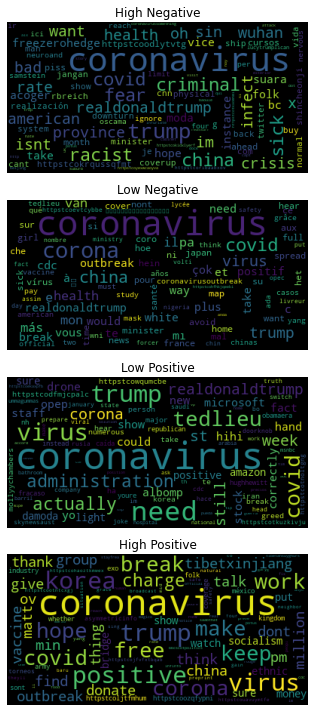

In [39]:
createTermFrequency()

In [25]:
tempDF = spark.sql("""select event_date,coordinates,geo,place,text from marchTweetsPart3""")
cleanDFa = pipeline.fit(tempDF).transform(tempDF) # without stop words
tokenDFa = cleanDFa.withColumn("exploded_text", explode(col("finished_clean_lemma"))).withColumn('sentiment',calc_polarity('text'))
tokenDFa.createOrReplaceTempView("cleanTokens")
spark.sql("""select sentiment, count(*) from cleanTokens group by sentiment""").show(10)

+---------+--------+
|sentiment|count(1)|
+---------+--------+
|       LN|    1913|
|       HP|     912|
|       HN|     732|
|       LP|     338|
+---------+--------+



+-----------+-----+
|       text|count|
+-----------+-----+
|coronavirus|   17|
|      trump|    4|
+-----------+-----+
only showing top 2 rows



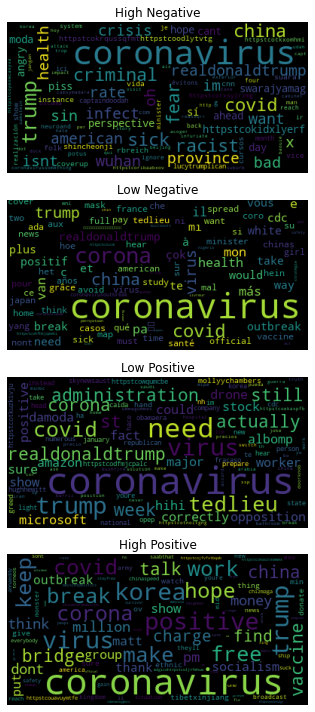

In [41]:
createTermFrequency()

In [24]:
tempDF = spark.sql("""select event_date,coordinates,geo,place,text from marchTweetsPart4""")
cleanDFa = pipeline.fit(tempDF).transform(tempDF) # without stop words
tokenDFa = cleanDFa.withColumn("exploded_text", explode(col("finished_clean_lemma"))).withColumn('sentiment',calc_polarity('text'))
tokenDFa.createOrReplaceTempView("cleanTokens")
spark.sql("""select sentiment, count(*) from cleanTokens group by sentiment""").show(10)

+---------+--------+
|sentiment|count(1)|
+---------+--------+
|       LN|     418|
|       HP|     121|
|       HN|     119|
|       LP|      56|
+---------+--------+



+-----------+-----+
|       text|count|
+-----------+-----+
|coronavirus|   17|
|      trump|    4|
+-----------+-----+
only showing top 2 rows



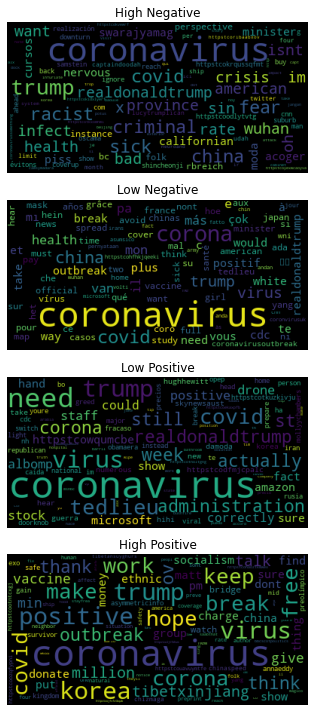

In [42]:
createTermFrequency()

In [38]:
def wordcloudV2(corpus_sdf):
    corpus_pdf = corpus_sdf.limit(500).toPandas()

    corpus_dict = {}
    for index, row in corpus_pdf.iterrows():
        corpus_dict[row['text']] = row['count']
        
    wordcloudVar = WordCloud().generate_from_frequencies(corpus_dict)
    return wordcloudVar

def createTermFrequency():
    countTermDFa = spark.sql("""select exploded_text as text, count(*) as count from cleanTokens where sentiment like "HN" group by exploded_text""")
    countTermDFa.createOrReplaceTempView("tempTable")
    countTermDFQry = 'select text, count from tempTable where lower(text) not rlike ("get|say|en|el|de|rt|se|le|para|la|los|les|por|di|like|queue|un|es|today|anyone|may|una|also|amp|lo|sus|go|agua|con|get|que|manas") order by count desc limit 100'
    topTermsDFa = spark.sql(countTermDFQry)
    topTermsDFa.show(2)
    hnwc = wordcloudV2(topTermsDFa)
    
    countTermDFa = spark.sql("""select exploded_text as text, count(*) as count from cleanTokens where sentiment like "LN" group by exploded_text""")
    countTermDFa.createOrReplaceTempView("tempTable")
    countTermDFQry = 'select text, count from tempTable where lower(text) not rlike ("get|say|en|el|de|rt|se|le|para|la|los|les|por|di|like|queue|un|es|today|anyone|may|una|also|amp|lo|sus|go|agua|con|get|que|manas") order by count desc limit 100'
    topTermsDFa = spark.sql(countTermDFQry)
    lnwc = wordcloudV2(topTermsDFa)
    
    countTermDFa = spark.sql("""select exploded_text as text, count(*) as count from cleanTokens where sentiment like "LP" group by exploded_text""")
    countTermDFa.createOrReplaceTempView("tempTable")
    countTermDFQry = 'select text, count from tempTable where lower(text) not rlike ("get|say|en|el|de|rt|se|le|para|la|los|les|por|di|like|queue|un|es|today|anyone|may|una|also|amp|lo|sus|go|agua|con|get|que|manas") order by count desc limit 100'
    topTermsDFa = spark.sql(countTermDFQry)
    lpwc = wordcloudV2(topTermsDFa)
    
    countTermDFa = spark.sql("""select exploded_text as text, count(*) as count from cleanTokens where sentiment like "HP" group by exploded_text""")
    countTermDFa.createOrReplaceTempView("tempTable")
    countTermDFQry = 'select text, count from tempTable where lower(text) not rlike ("get|say|en|el|de|rt|se|le|para|la|los|les|por|di|like|queue|un|es|today|anyone|may|una|also|amp|lo|sus|go|agua|con|get|que|manas") order by count desc limit 100'
    topTermsDFa = spark.sql(countTermDFQry)
    hpwc = wordcloudV2(topTermsDFa)
        
    fig, ax = plt.subplots(nrows=4, figsize=(10,10))
    ax[0].imshow(hnwc)
    ax[0].set_title('High Negative')
    ax[0].axis('off')
    
    ax[1].imshow(lnwc)
    ax[1].set_title('Low Negative')
    ax[1].axis('off')
    
    ax[2].imshow(lpwc)
    ax[2].set_title('Low Positive')
    ax[2].axis('off')
    
    ax[3].imshow(hpwc)
    ax[3].set_title('High Positive')
    ax[3].axis('off')
    
    plt.tight_layout();
    
    
    #spark.catalog.dropTempView(clusterType)

## Geo Loaction